In [26]:
import dbCycles
import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [59]:
def getFormattedDate(_date=None, shiftDays=0):
    formatString = "%Y-%m-%d"
    if _date == None:
        _date = datetime.datetime.now()
    else:
        _date = datetime.datetime.strptime(_date, formatString)
    _date = _date - datetime.timedelta(days=shiftDays)

    return _date.strftime(formatString)

#Looks at past data per cycles. First need to go back per cycle or number of
# days. Query DB: Select Date when active = 1. Then query each cycle per
# query. Add Plot.ly plot. This should be called from the front end?
def getHistoricDataV2(numOfCycles=3):

    #Fetch start date of cycles
    data = db.getCycleDates(numOfCycles)

    #https://stackoverflow.com/questions/10632839/transform-list-of-tuples-into-a-flat-list-or-a-matrix
    startDateList = list(sum(data, ()))

    #Add today's date to list. Reverse to start with most recent
    startDateList.append( getFormattedDate() )
    startDateList.reverse()

    #Create empty list to store each DF. Each DF is a cycle
    dfs = []

    #Loop through start dates except last date
    for idx,startDate in enumerate(startDateList[:-1]):
        endDate = startDateList[idx+1]

        rawDataList = db.getActiveRecordsForDateRange(startDate, endDate)

        title = ['ID', 'Record Date', 'Active', 'TimeStamp', 'Monitor', 'SexyTime',
                 'Green Day', 'New Cycle']

        tempDF = pd.DataFrame(rawDataList)
        tempDF.columns = title

        tempDF.sort_values('Record Date', inplace=True, ascending=False)
        
        #Need to remove row 1 if idx > 1

        #Add column with increasing integer to aid in plot later on
        tempIntList = np.arange(tempDF.shape[0])
        
        tempDF['Cycle Count'] = tempIntList[::-1]
        
        #Create figures
        fig = px.line(tempDF, x='Record Date', y='Monitor', markers=True)
        #Format date and center point
        fig.update_xaxes(tickformat='%Y-%m-%d', ticklabelmode='period')

        #Convert to list of dicts. {'plot':..., 'cycleLength':..., 
        
        dfs.append(tempDF)
        #dfs.append(fig.to_html(include_plotlyjs='cdn', full_html=False))

    return dfs
    
db = dbCycles.cycleDBClass()

dfsTemp = getHistoricDataV2()

In [37]:
dfsTemp[0]

,ID,Record Date,Active,TimeStamp,Monitor,SexyTime,Green Day,New Cycle,Cycle Count
0,1,2022-09-27,1,2022-09-27 21:43:09.137888,5,0,1,0,15
1,2,2022-09-26,1,2022-09-26 21:43:10.337144,4,0,0,0,14
2,3,2022-09-25,1,2022-09-25 21:43:10.390629,3,0,1,0,13
3,4,2022-09-24,1,2022-09-24 21:43:10.441803,11,1,1,0,12
4,5,2022-09-23,1,2022-09-23 21:43:10.490332,8,1,1,0,11
5,6,2022-09-22,1,2022-09-22 21:43:10.550775,2,1,1,0,10
6,7,2022-09-21,1,2022-09-21 21:43:10.596313,3,0,1,0,9
7,8,2022-09-20,1,2022-09-20 21:43:10.658630,7,1,1,0,8
8,9,2022-09-19,1,2022-09-19 21:43:10.696904,12,0,1,0,7
9,10,2022-09-18,1,2022-09-18 21:43:10.706600,23,1,0,0,6


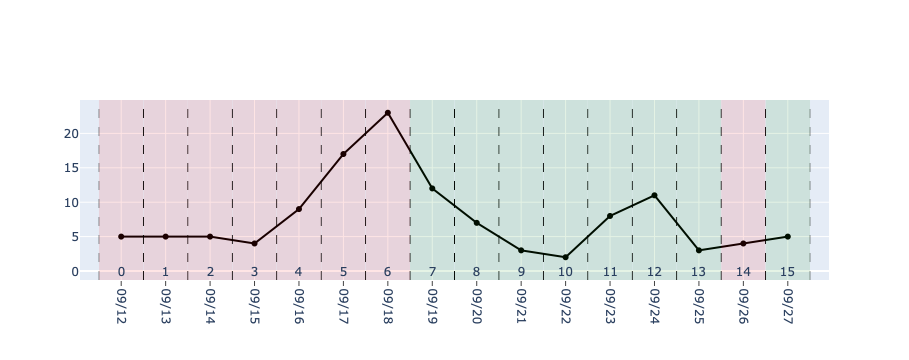

In [79]:
fig = go.Figure()

#Add Cycle Count. Pandas not supported
dates = dfsTemp[0]['Record Date'].tolist()
text = dfsTemp[0]['Cycle Count'].tolist()
for i in range(len(dates)):
    fig.add_annotation(x=dates[i], y=0,
            text=text[i],
            showarrow=False,
            arrowhead=1)

color = dfsTemp[0]['Green Day'].tolist()
for i in range(len(dates)):
    startRect = datetime.datetime.strptime(dates[i], '%Y-%m-%d')
    startRect = startRect - datetime.timedelta(days=0.5)
    startRect = startRect.strftime('%Y-%m-%d %H:%M')
    
    endRect = datetime.datetime.strptime(dates[i], '%Y-%m-%d')
    endRect = endRect + datetime.timedelta(days=0.5)
    endRect = endRect.strftime('%Y-%m-%d %H:%M')
    
    
    fig.add_vline(x=startRect, line_width=1, line_dash="dash", line_color="black", opacity=0.8)
    fig.add_vline(x=endRect, line_width=1, line_dash="dash", line_color="black", opacity=0.8)
    
    if color[i] == 0:
        fig.add_vrect(x0=startRect, x1=endRect, line_width=0, fillcolor="red", opacity=0.1)
    else:
        fig.add_vrect(x0=startRect, x1=endRect, line_width=0, fillcolor="green", opacity=0.1)
 

fig.add_trace(go.Scatter(x=dfsTemp[0]['Record Date'],
                         y=dfsTemp[0]['Monitor'],
                         text=dfsTemp[0]['Cycle Count'],
                         mode='lines+markers',
                         line_color='black'))



fig.update_xaxes(
    tickformat='%m/%d',
    tickangle = 90,
    dtick=86400000, #dticks is in milliseconds
    ticks='outside',
    tickson='boundaries') 
              
fig.show()

In [25]:
fig = px.line(dfsTemp[0], x='Record Date', y='Monitor', text="country", markers=True)

#Format date and center point 
fig.update_xaxes(tickformat='%Y-%m-%d', ticklabelmode='period')

#Add Count above or below plot

#Add lines per date or split up background - https://community.plotly.com/t/px-timeline-vertical-line-to-indicate-certain-date/55137/2

#Add Green/Red days - colorscale - https://github.com/plotly/plotly.js/issues/5238

fig.show()

ValueError: Value of 'text' is not the name of a column in 'data_frame'. Expected one of ['ID', 'Record Date', 'Active', 'TimeStamp', 'Monitor', 'SexyTime', 'Green Day', 'New Cycle', 'Cycle Count'] but received: country

In [ ]:
fig.to_html(include_plotlyjs=False, full_html=False)